In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd "/content/drive/MyDrive/vihsd"

/content/drive/MyDrive/vihsd


# Library

In [11]:
pip install pyvi

In [12]:
!pip install tensorflow==2.12 keras==2.12

# Data loader

In [16]:
!ls "/content/drive/MyDrive/vihsd/data"


vihsd  vihsd.zip


In [18]:
import pandas as pd
import numpy as np

DATA = 'data/vihsd/vihsd/train.csv'
DEV_DATA = 'data/vihsd/vihsd/dev.csv'
TEST_DATA = 'data/vihsd/vihsd/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_dev = dev_data['free_text']
y_dev = dev_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

24048
2672
6680


In [21]:
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt -O /content/drive/MyDrive/vihsd/data/vietnamese-stopwords-dash.txt


--2025-07-27 16:32:02--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘/content/drive/MyDrive/vihsd/data/vietnamese-stopwords-dash.txt’

/content/drive/MyDr 100%[===================>]  20.00K  --.-KB/s    in 0.002s  

2025-07-27 16:32:03 (10.4 MB/s) - ‘/content/drive/MyDrive/vihsd/data/vietnamese-stopwords-dash.txt’ saved [20475/20475]



In [23]:
import pandas as pd
import numpy as np

from pyvi.ViTokenizer import ViTokenizer

STOPWORDS = "/content/drive/MyDrive/vihsd/data/vietnamese-stopwords-dash.txt"
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     5897100     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 300, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 99, 1, 32)    19232       ['reshape[0][0]']                
                                                                                              

/usr/local/lib/python3.11/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


94/94 [==============================] - 103s 1s/step - loss: 0.8424 - accuracy: 0.7097 - val_loss: 0.6901 - val_accuracy: 0.8192
Epoch 2/40
94/94 [==============================] - 103s 1s/step - loss: 0.6246 - accuracy: 0.8269 - val_loss: 0.5810 - val_accuracy: 0.8196
Epoch 3/40
94/94 [==============================] - 101s 1s/step - loss: 0.5350 - accuracy: 0.8293 - val_loss: 0.5206 - val_accuracy: 0.8207
Epoch 4/40
94/94 [==============================] - 102s 1s/step - loss: 0.4853 - accuracy: 0.8367 - val_loss: 0.4882 - val_accuracy: 0.8301
Epoch 5/40
94/94 [==============================] - 103s 1s/step - loss: 0.4512 - accuracy: 0.8463 - val_loss: 0.4642 - val_accuracy: 0.8372
Epoch 6/40
94/94 [==============================] - 102s 1s/step - loss: 0.4236 - accuracy: 0.8528 - val_loss: 0.4457 - val_accuracy: 0.8409
Epoch 7/40
94/94 [==============================] - 101s 1s/step - loss: 0.3984 - accuracy: 0.8608 - val_loss: 0.4298 - val_accuracy: 0.8462
Epoch 8/40
94/94 [======

<Axes: >

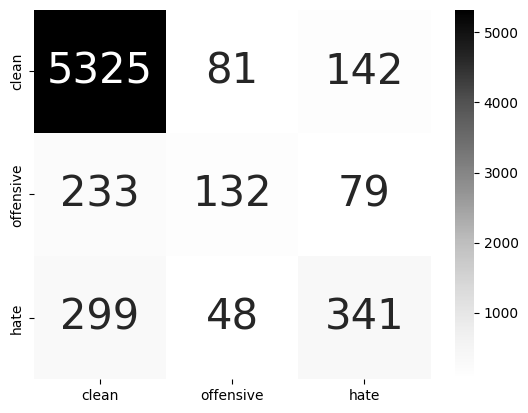

In [31]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = '/content/drive/MyDrive/vihsd/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/vihsd/model/Text_CNN_model_v13.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/vihsd/tokenizer/tokenizer.pickle'
, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)


inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## GRU (Gated Recurrent Units)

In [2]:
!pip install pyvi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00


In [9]:
# GRU
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, Bidirectional, GRU
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from pyvi.ViTokenizer import ViTokenizer

def pre_process_features(X, y, tokenized=True, lowercased=True):
    processed_X = []
    for text in X:
        if lowercased:
            text = text.lower()
        if tokenized:
            text = ViTokenizer.tokenize(text)
        processed_X.append(text)
    return processed_X, y

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

EMBEDDING_FILE = '/content/drive/MyDrive/vihsd/cc.vi.300.vec'
MODEL_FILE = '/content/drive/MyDrive/vihsd/model/GRU_model_v4.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/vihsd/tokenizer.pickle'
, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(3, activation="softmax")(conc)

# this creates a model that includes
model = Model(inputs=input, outputs=output)

model.summary()

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf2 = confusion_matrix(test_y, y_pred)
print(cf2)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm2 = pd.DataFrame(cf2, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/vihsd/data/train.csv'